#### 분류 결과 분석 (Visualize)
- 눈 분류 결과 분석

In [1]:
cd ../

/home/yujin/project/notebook/eye_detection


/home/yujin/miniconda3/envs/eye_cls/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

from eval import process_file, evaluate_model
from utils import load_mean_embedding, load_model, preprocess_image


In [3]:
# Configuration
threshold = 0.65
data_dir = "testset"
classes = {"eye": 1, "no eye": 0}
label_to_class = {v: k for k, v in classes.items()}

# # 튜닝 모델 사용
# embedding_file = "embedding_pkl/mean_embedding_tuning.pkl"
# mean_embedding = load_mean_embedding(file_path = embedding_file)

# tuning_status = True
# model_path = "models/mobilenetv3_large.pt"
# model = load_model(tuning_status=tuning_status, 
#                    model_path = model_path)


# 튜닝 안한 모델 사용
embedding_file = "embedding_pkl/mean_embedding.pkl"
mean_embedding = load_mean_embedding(file_path = embedding_file)
tuning_status = False
model = load_model(tuning_status=tuning_status)


In [4]:
def process_files_in_directory(model, mean_embedding, threshold):
    """Process all files in the dataset directory."""
    y_true, y_pred = [], []
    mismatched_files, matched_files = [], []

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []

        for label_dir, label in classes.items():
            class_path = os.path.join(data_dir, str(label))

            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                futures.append(
                    executor.submit(
                        process_file, model, file_path, label, mean_embedding, threshold
                    )
                )

        for future in tqdm(futures, desc="Evaluating", total=len(futures)):
            file_name, label, prediction = future.result()
            y_true.append(label)
            y_pred.append(prediction)

            if label != prediction:
                mismatched_files.append((file_name, label_to_class.get(label), label_to_class.get(prediction)))
            else:
                matched_files.append((file_name, label_to_class.get(label), label_to_class.get(prediction)))

    return y_true, y_pred, mismatched_files, matched_files

def visualize_samples(sampled_files, title, num_samples=64, seed=42):
    """Visualize a set of sampled files."""
    random.seed(seed)
    sampled_files = random.sample(sampled_files, min(num_samples, len(sampled_files)))

    cols = 8
    rows = (len(sampled_files) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(sampled_files):
            file_name, true_label, pred_label = sampled_files[i]
            preprocessed_image = preprocess_image(file_name)
            image_np = preprocessed_image.squeeze(0).permute(1, 2, 0).numpy()
            image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            image_np = image_np.clip(0, 1)

            ax.imshow(image_np)
            ax.axis("off")
            ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        else:
            ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

Evaluating:   0%|          | 0/554 [00:00<?, ?it/s]

Evaluation Metrics: {'valid/accuracy': 0.8050541281700134, 'valid/f1_score': 0.7578475475311279, 'valid/precision': 1.0, 'valid/recall': 0.6101083159446716, 'valid/specificity': 1.0}


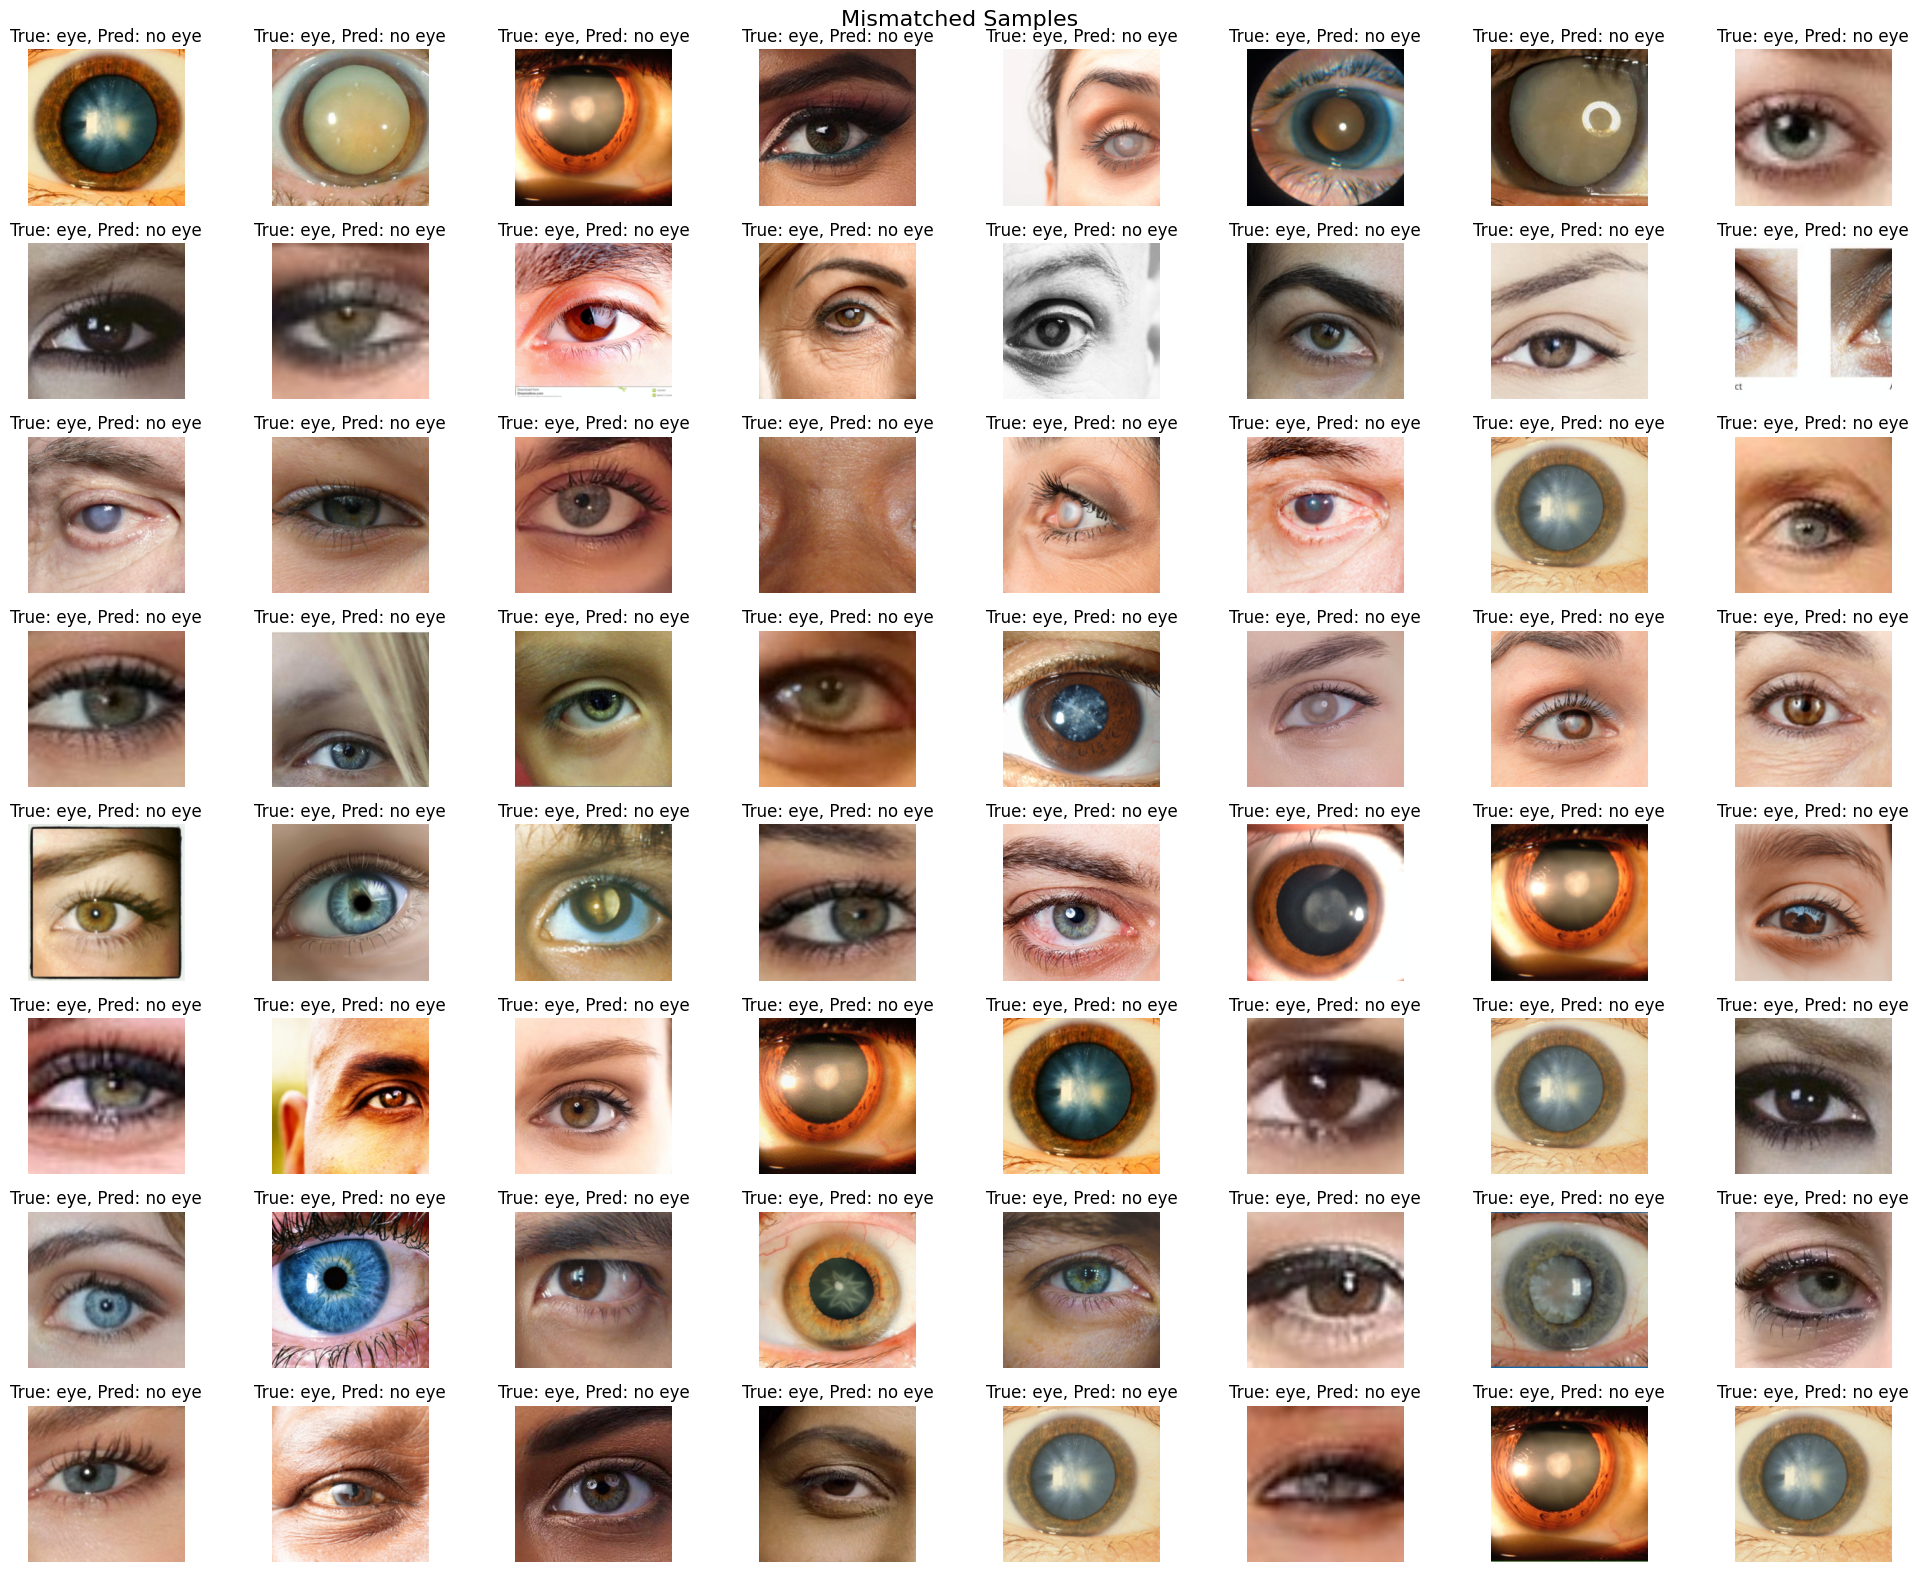

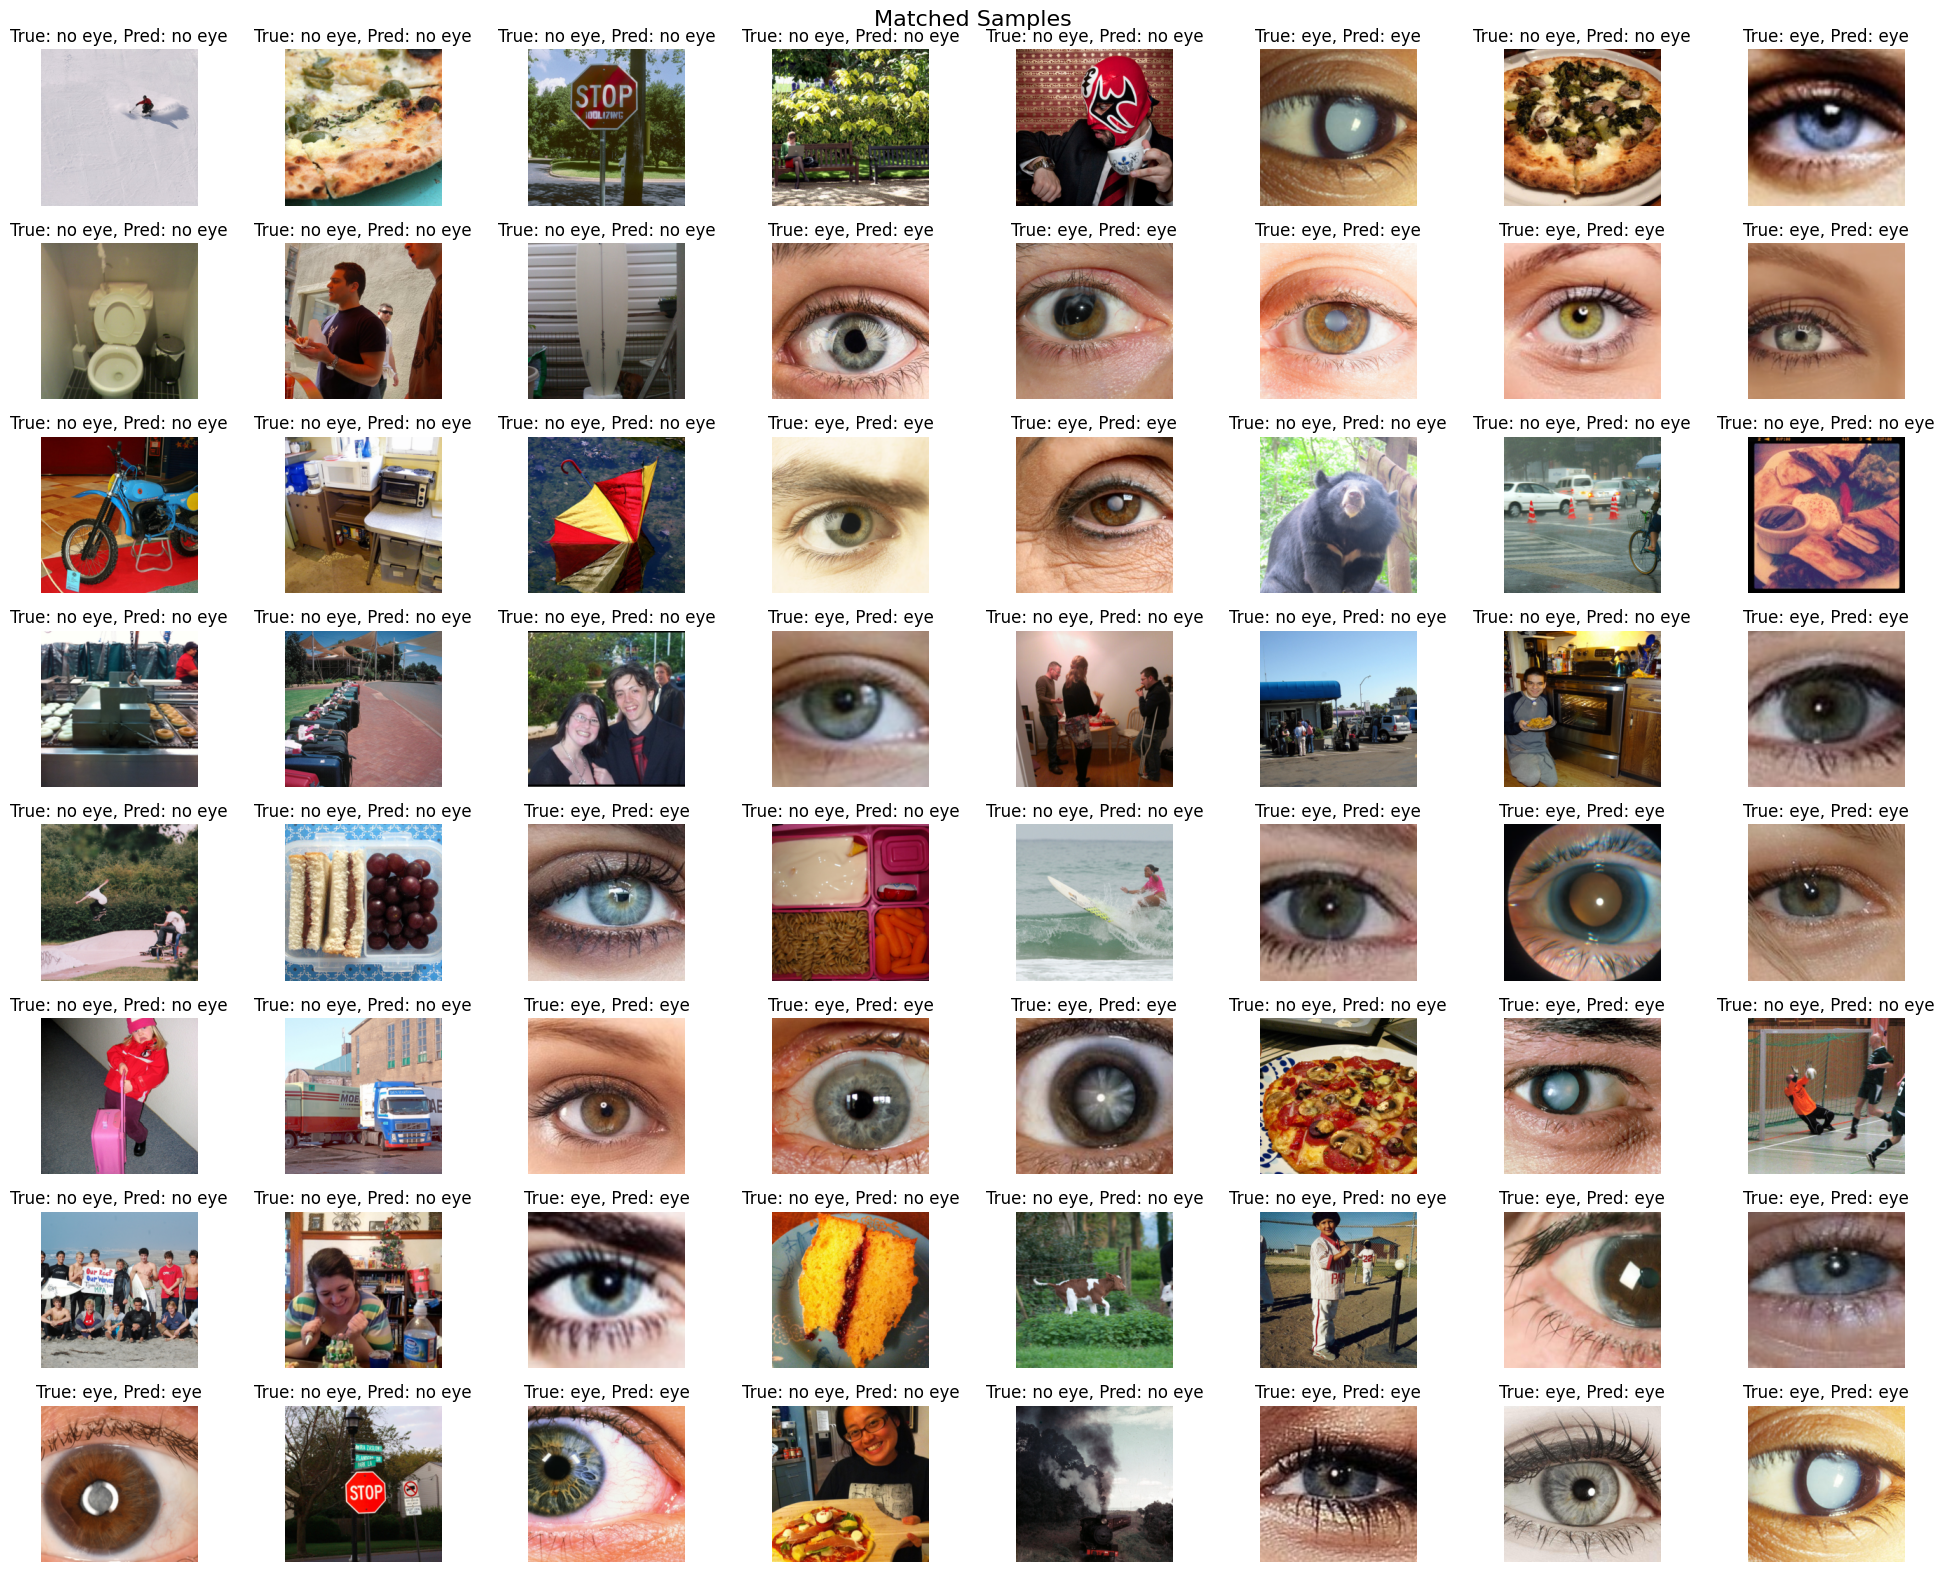

In [5]:
# Process files
y_true, y_pred, mismatched_files, matched_files = process_files_in_directory(model, mean_embedding, threshold)

# Evaluate model
metrics = evaluate_model(y_true, y_pred)
print("Evaluation Metrics:", metrics)

# Visualize mismatched samples
visualize_samples(mismatched_files, title="Mismatched Samples", num_samples=64, seed=212)

# Visualize matched samples
visualize_samples(matched_files, title="Matched Samples", num_samples=64, seed=2123)
